In [1]:
import os
os.environ["TORCHAUDIO_BACKEND"] = "sox_io"
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import random

## Import packages

In [2]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) *
                             (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) # even index
        pe[:, 1::2] = torch.cos(position * div_term) # odd index
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe) # pe is not a parameter but a buffer
        # → Because pe is not a learning target and must remain a fixed value.

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :] # add positional encoding info to input
        return x

## Positional Encoding:   
위치 인코딩`Positional Encoding`은 `Transformer` 모델에서 순서 정보(sequence order)를 제공하기 위해 사용된다.
CNN이나 RNN과 달리, Transformer는 입력 시퀀스에서 순서 정보가 없기 때문에 이를 보완하기 위해 위치 정보를 임베딩에 추가해야한다.

#### pe: 위치 인코딩 값을 저장할 행렬
* `d_model`: 입력 차원 (Transformer에서 사용할 임베딩 차원).   
* `max_len`: 최대 시퀀스 길이 (일반적으로 충분히 크게 설정, 여기서는 5000).   
* `pe`: 위치 인코딩 값을 저장할 행렬 (max_len × d_model 크기, 모든 값 0으로 초기화).

#### position: 위치 벡터
* `torch.arange(0, max_len)`: 0부터 max_len - 1까지 정수 벡터를 생성 (각 단어의 위치 표현). // 1차원 벡터   
* `.unsqueeze(1)`: 차원을 (max_len, 1)로 변환하여 연산할 수 있도록 함. // 1차원 -> 2차원 변환

```bash
position = [[0],
            [1],
            [2],
            [3]]
```
* `torch.arange(start, stop, step)`: 지정된 범위에서 일정한 간격으로 숫자를 생성하는 함수.
* `start=0, stop=d_model, step=2`: 즉, 0, 2, 4, ... 이렇게 짝수 인덱스만 선택.
* `dtype=torch.float32`: 실수(float)로 변환



#### div_term: 위치 인코딩의 주기성을 설정
* `torch.arange(0, d_model, 2)`: 짝수 인덱스 (0, 2, 4, ...)만 선택.
* `torch.log(torch.tensor(10000.0)) / d_model`: 주기적인 변화를 조정하는 스케일링 값.
* `torch.exp(...)`: 지수 함수를 사용하여 10000^(2i/d_model)의 역수를 계산.

$$
\frac{1}{10000^{\frac{2i}{d_{model}}}}
$$

이 식을 로그 변환하면:

$$
\log \left( \frac{1}{10000^{\frac{2i}{d_{model}}}} \right) = -\frac{\log(10000)}{d_{model}} \times 2i
$$

즉, 
$$
\frac{1}{10000^{\frac{2i}{d_{model}}}}
$$ 
를 직접 계산하는 대신, **로그를 이용해 곱셈(`*`) 연산으로 변환**하면 더 빠르고 안정적으로 계산

#### self.register_buffer: pe를 모델의 파라미터가 아닌 버퍼로 설정
* pe 텐서는 위치 정보를 가지고 있고, 학습 시 업데이트가 되면 안되므로 모델의 버퍼로 설정하여 고정된 값을 가지도록 해야함.


In [10]:
# SpeechCommands 데이터셋의 서브셋 클래스
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./data", download=True)
        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            if not os.path.exists(filepath):
                return []
            with open(filepath) as f:
                return [os.path.join(self._path, line.strip()) for line in f]
        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

## create Subset
: Data set으로부터 포함된 list.txt을 이용하여 training set, validation set, testing set을 분류한다.

In [11]:
# Transformer 기반 음성 명령 인식 모델
class SpeechTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=8, num_layers=4, 
                 dim_feedforward=512, dropout=0.1, max_len=5000):
        super(SpeechTransformer, self).__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, 
            dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, num_classes)
        
    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        return self.classifier(x)

## Transformer encoder
: 4개의 encoder layer Model

In [12]:
# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_predictions, average='macro', zero_division=0
    )
    return accuracy, precision, recall, f1

In [13]:
# 학습 및 평가 실행 함수
def run_training_and_evaluation(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs):
    train_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1s = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
        test_accuracies.append(accuracy)
        test_precisions.append(precision)
        test_recalls.append(recall)
        test_f1s.append(f1)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, "
              f"Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, "
              f"Recall: {recall*100:.2f}%, F1-score: {f1*100:.2f}%")
    return train_losses, test_accuracies, test_precisions, test_recalls, test_f1s

In [14]:
# 샘플 데이터 시각화 함수
def visualize_samples(dataset, transform, num_samples=5):
    indices = random.sample(range(len(dataset)), num_samples) # Python의 random.sample() 함수는 리스트를 반환하는 내장 함수
    fig, axs = plt.subplots(num_samples, 2, figsize=(12, 3 * num_samples))
    for i, idx in enumerate(indices):
        waveform, sr, label, *_ = dataset[idx]
        mel_spec = transform(waveform).mean(dim=0)  # 채널 평균
        
        # 파형 시각화
        axs[i, 0].plot(waveform.t().numpy())
        axs[i, 0].set_title(f"Waveform - Label: {label}")
        axs[i, 0].set_xlabel("Time")
        axs[i, 0].set_ylabel("Amplitude")
        
        # Mel-spectrogram 시각화
        im = axs[i, 1].imshow(mel_spec.numpy(), origin='lower', aspect='auto', cmap='viridis')
        axs[i, 1].set_title(f"Mel-Spectrogram - Label: {label}")
        axs[i, 1].set_xlabel("Time")
        axs[i, 1].set_ylabel("Mel Frequency Bin")
        fig.colorbar(im, ax=axs[i, 1])
    plt.tight_layout()
    plt.show()

fig → 전체 그림(Figure) 객체 (개별 axs들을 포함)
axs → 개별 그래프(Axes) 객체들이 들어 있는 배열 

In [15]:
def main():
    transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128)
    train_set = SubsetSC("training") # (waveform.shape, sample_rate, label)
    test_set = SubsetSC("testing") # (waveform.shape, sample_rate, label)

    # 데이터 시각화: 5개 샘플의 파형, Mel-spectrogram, 라벨 표시
    visualize_samples(train_set, transform, num_samples=5)

    labels = sorted(list(set(dat[2] for dat in train_set)))
    label_to_idx = {label: idx for idx, label in enumerate(labels)}

    def collate_fn(batch):
        waveforms, targets = [], []
        for waveform, sample_rate, label, *_ in batch:
            mel_spec = transform(waveform).mean(dim=0).transpose(0, 1)
            waveforms.append(mel_spec)
            targets.append(label_to_idx[label])
        waveforms = nn.utils.rnn.pad_sequence(waveforms, batch_first=True)
        return waveforms, torch.tensor(targets)

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_fn)

    input_dim = 128
    num_classes = len(labels)
    model = SpeechTransformer(input_dim=input_dim, num_classes=num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    epochs = 10
    train_losses, test_accuracies, test_precisions, test_recalls, test_f1s = run_training_and_evaluation(
        model, train_loader, test_loader, criterion, optimizer, scheduler, epochs
    )

    # 시각화: 학습 손실, 정확도, Precision, Recall, F1-score 그래프
    epochs_range = range(1, epochs + 1)
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # 첫 번째 서브플롯: Loss & Accuracy
    ax1 = axs[0]
    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs_range, train_losses, color=color, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax1b = ax1.twinx()
    color = 'tab:red'
    ax1b.set_ylabel('Accuracy', color=color)
    ax1b.plot(epochs_range, test_accuracies, color=color, label='Test Accuracy')
    ax1b.tick_params(axis='y', labelcolor=color)
    ax1b.legend(loc='upper right')

    # 두 번째 서브플롯: Precision, Recall, F1-score
    ax2 = axs[1]
    ax2.plot(epochs_range, test_precisions, label='Precision')
    ax2.plot(epochs_range, test_recalls, label='Recall')
    ax2.plot(epochs_range, test_f1s, label='F1-score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()
    ax2.set_title('Precision, Recall, and F1-score over Epochs')

    plt.tight_layout()
    plt.show()

c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
100.0%


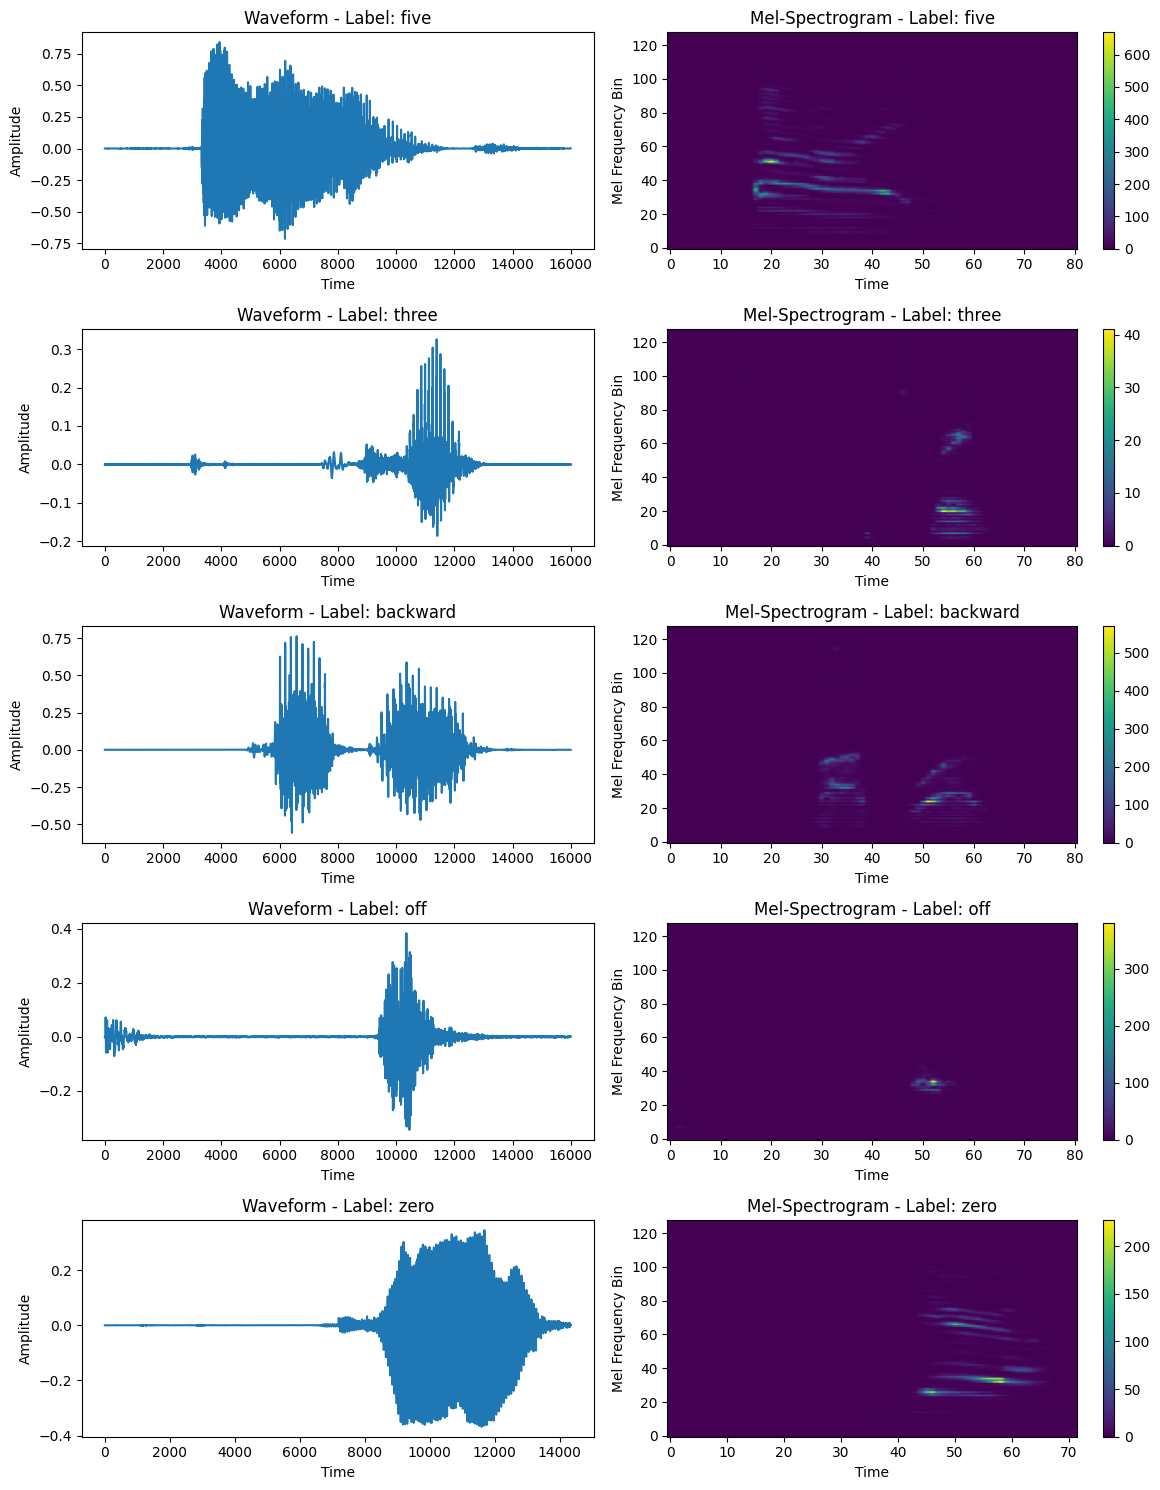

c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 2.0199, Accuracy: 58.16%, Precision: 60.77%, Recall: 54.85%, F1-score: 55.74%
Epoch 2/10, Loss: 1.3365, Accuracy: 64.92%, Precision: 68.35%, Recall: 61.61%, F1-score: 62.10%
Epoch 3/10, Loss: 1.1293, Accuracy: 70.91%, Precision: 73.23%, Recall: 67.34%, F1-score: 67.75%
Epoch 4/10, Loss: 1.0226, Accuracy: 69.98%, Precision: 72.70%, Recall: 67.84%, F1-score: 69.04%
Epoch 5/10, Loss: 0.9791, Accuracy: 73.98%, Precision: 74.53%, Recall: 71.92%, F1-score: 72.34%
Epoch 6/10, Loss: 0.6126, Accuracy: 85.65%, Precision: 85.07%, Recall: 84.18%, F1-score: 84.48%
Epoch 7/10, Loss: 0.5155, Accuracy: 87.22%, Precision: 87.19%, Recall: 85.69%, F1-score: 86.27%
Epoch 8/10, Loss: 0.4726, Accuracy: 88.03%, Precision: 87.42%, Recall: 86.86%, F1-score: 87.09%
Epoch 9/10, Loss: 0.4399, Accuracy: 88.67%, Precision: 88.43%, Recall: 87.19%, F1-score: 87.65%
Epoch 10/10, Loss: 0.4126, Accuracy: 90.01%, Precision: 89.86%, Recall: 88.77%, F1-score: 89.24%


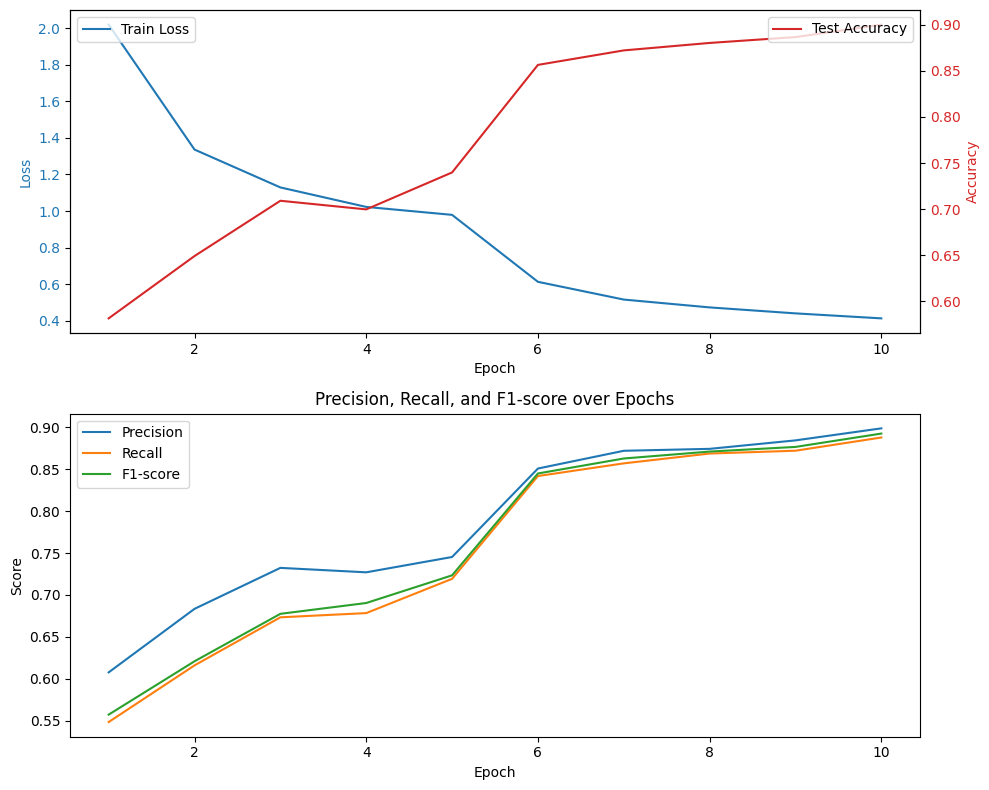

In [9]:
if __name__ == '__main__':
    main()